__<center>3º Deliverable: Machine Learning</center>__

__<center>Life insurance policy</center>__

<div>
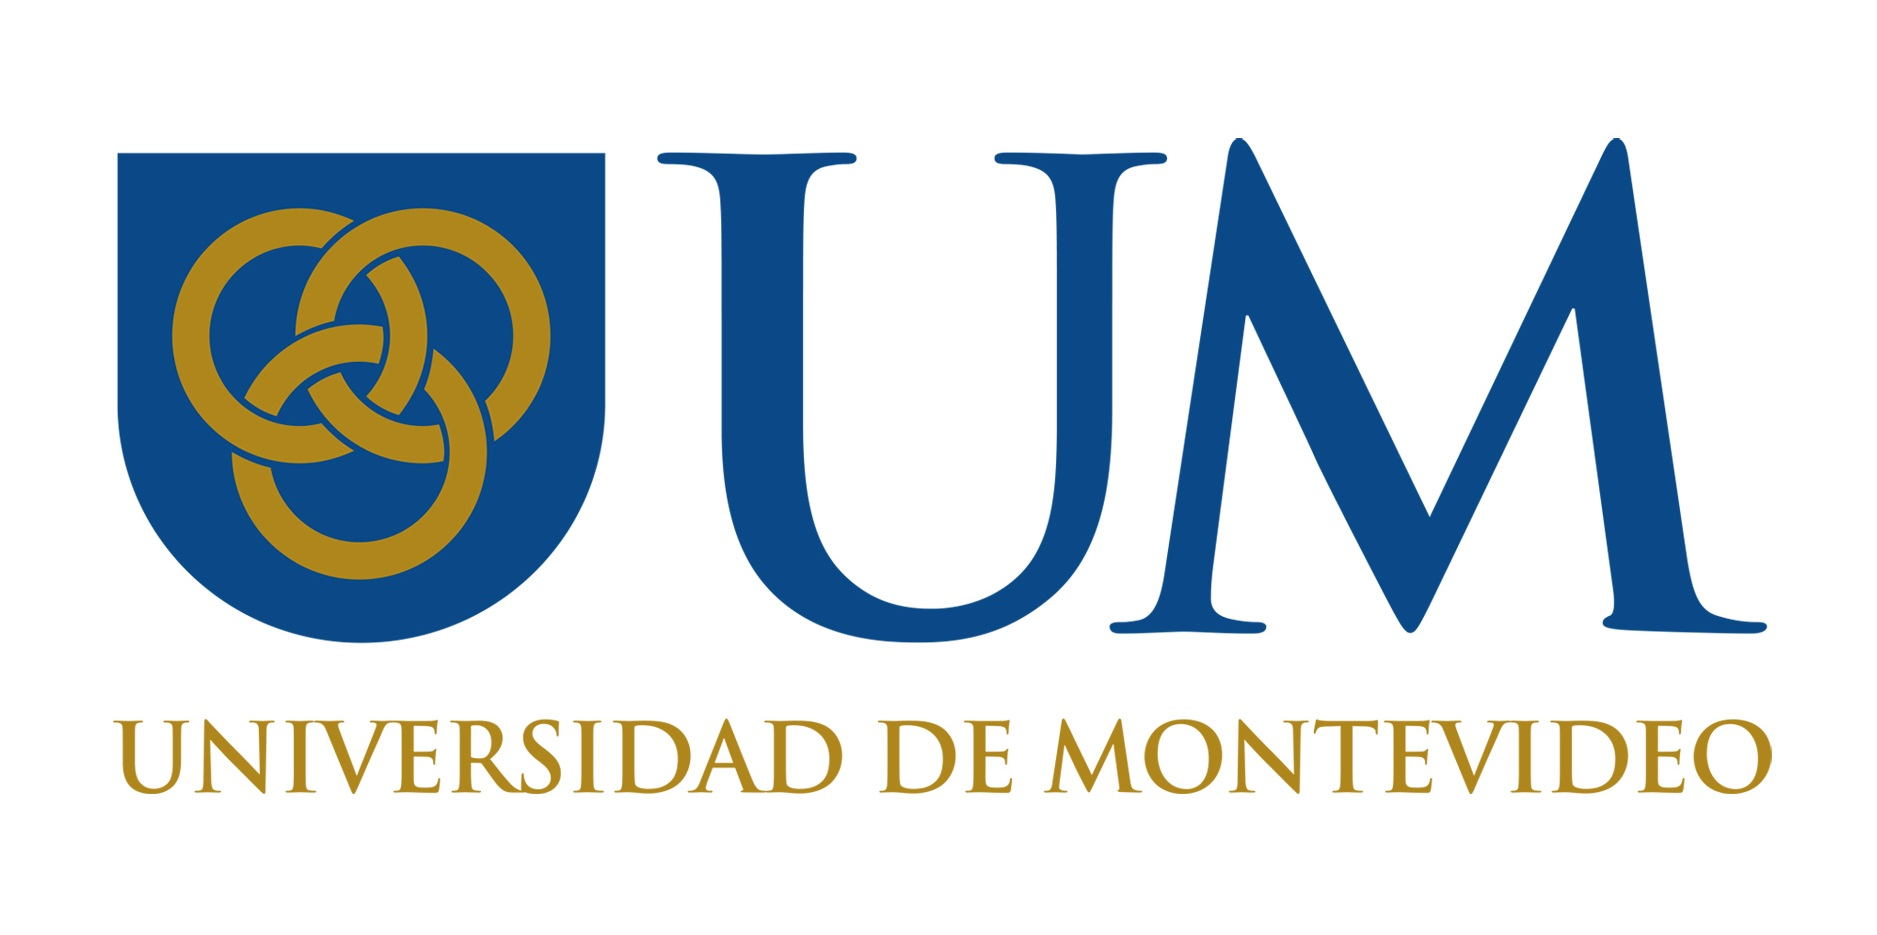
</div>


<center>Team VIII: Ariel Mordetzki and Mateo Stipaničić</center>
<center>Prof. Sebastián García Parra</center>
<center>November 2022</center>

___


<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Outline" data-toc-modified-id="Outline-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Outline</a></span><ul class="toc-item"><li><span><a href="#System's-flow-diagram" data-toc-modified-id="System's-flow-diagram-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>System's flow diagram</a></span></li></ul></li><li><span><a href="#Registration-form" data-toc-modified-id="Registration-form-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Registration form</a></span><ul class="toc-item"><li><span><a href="#Synthetic-dataset-creation" data-toc-modified-id="Synthetic-dataset-creation-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Synthetic dataset creation</a></span><ul class="toc-item"><li><span><a href="#Data-analysis-on-synthetic-dataset" data-toc-modified-id="Data-analysis-on-synthetic-dataset-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>Data analysis on synthetic dataset</a></span><ul class="toc-item"><li><span><a href="#Dataset-configuration" data-toc-modified-id="Dataset-configuration-2.1.1.1"><span class="toc-item-num">2.1.1.1&nbsp;&nbsp;</span>Dataset configuration</a></span></li><li><span><a href="#Data-cleaning-and-pre-processing" data-toc-modified-id="Data-cleaning-and-pre-processing-2.1.1.2"><span class="toc-item-num">2.1.1.2&nbsp;&nbsp;</span>Data cleaning and pre-processing</a></span></li><li><span><a href="#Dataset-discussion" data-toc-modified-id="Dataset-discussion-2.1.1.3"><span class="toc-item-num">2.1.1.3&nbsp;&nbsp;</span>Dataset discussion</a></span></li></ul></li></ul></li><li><span><a href="#Clustering-model" data-toc-modified-id="Clustering-model-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Clustering model</a></span><ul class="toc-item"><li><span><a href="#Clustering-analysis" data-toc-modified-id="Clustering-analysis-2.2.1"><span class="toc-item-num">2.2.1&nbsp;&nbsp;</span>Clustering analysis</a></span></li><li><span><a href="#Conclusions-on-clustering-model" data-toc-modified-id="Conclusions-on-clustering-model-2.2.2"><span class="toc-item-num">2.2.2&nbsp;&nbsp;</span>Conclusions on clustering model</a></span></li></ul></li><li><span><a href="#Classification-model" data-toc-modified-id="Classification-model-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Classification model</a></span></li></ul></li><li><span><a href="#Clinical-records-information" data-toc-modified-id="Clinical-records-information-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Clinical records information</a></span><ul class="toc-item"><li><span><a href="#Data-analysis-on-clinical-records-dataset" data-toc-modified-id="Data-analysis-on-clinical-records-dataset-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Data analysis on clinical records dataset</a></span><ul class="toc-item"><li><span><a href="#Dataset-configuration" data-toc-modified-id="Dataset-configuration-3.1.1"><span class="toc-item-num">3.1.1&nbsp;&nbsp;</span>Dataset configuration</a></span></li><li><span><a href="#Data-cleaning-and-pre-processing" data-toc-modified-id="Data-cleaning-and-pre-processing-3.1.2"><span class="toc-item-num">3.1.2&nbsp;&nbsp;</span>Data cleaning and pre-processing</a></span></li><li><span><a href="#Dataset-discussion" data-toc-modified-id="Dataset-discussion-3.1.3"><span class="toc-item-num">3.1.3&nbsp;&nbsp;</span>Dataset discussion</a></span></li></ul></li><li><span><a href="#Key-clinical-variables" data-toc-modified-id="Key-clinical-variables-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Key clinical variables</a></span><ul class="toc-item"><li><span><a href="#Decision-tree-for-key-variables" data-toc-modified-id="Decision-tree-for-key-variables-3.2.1"><span class="toc-item-num">3.2.1&nbsp;&nbsp;</span>Decision tree for key variables</a></span></li><li><span><a href="#Random-forest-for-key-variables" data-toc-modified-id="Random-forest-for-key-variables-3.2.2"><span class="toc-item-num">3.2.2&nbsp;&nbsp;</span>Random forest for key variables</a></span></li><li><span><a href="#Key-variables-discussion" data-toc-modified-id="Key-variables-discussion-3.2.3"><span class="toc-item-num">3.2.3&nbsp;&nbsp;</span>Key variables discussion</a></span></li></ul></li><li><span><a href="#Classification-model-on-clinical-dataset" data-toc-modified-id="Classification-model-on-clinical-dataset-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Classification model on clinical dataset</a></span><ul class="toc-item"><li><span><a href="#Decision-tree-and-random-forest" data-toc-modified-id="Decision-tree-and-random-forest-3.3.1"><span class="toc-item-num">3.3.1&nbsp;&nbsp;</span>Decision tree and random forest</a></span></li><li><span><a href="#More-classification-methods" data-toc-modified-id="More-classification-methods-3.3.2"><span class="toc-item-num">3.3.2&nbsp;&nbsp;</span>More classification methods</a></span><ul class="toc-item"><li><span><a href="#SVM" data-toc-modified-id="SVM-3.3.2.1"><span class="toc-item-num">3.3.2.1&nbsp;&nbsp;</span>SVM</a></span></li><li><span><a href="#Logistic-Regression" data-toc-modified-id="Logistic-Regression-3.3.2.2"><span class="toc-item-num">3.3.2.2&nbsp;&nbsp;</span>Logistic Regression</a></span></li><li><span><a href="#k-NN" data-toc-modified-id="k-NN-3.3.2.3"><span class="toc-item-num">3.3.2.3&nbsp;&nbsp;</span>k-NN</a></span></li><li><span><a href="#Perceptron" data-toc-modified-id="Perceptron-3.3.2.4"><span class="toc-item-num">3.3.2.4&nbsp;&nbsp;</span>Perceptron</a></span></li></ul></li><li><span><a href="#Classification-models-discussion" data-toc-modified-id="Classification-models-discussion-3.3.3"><span class="toc-item-num">3.3.3&nbsp;&nbsp;</span>Classification models discussion</a></span><ul class="toc-item"><li><span><a href="#Testing-metrics:-summary" data-toc-modified-id="Testing-metrics:-summary-3.3.3.1"><span class="toc-item-num">3.3.3.1&nbsp;&nbsp;</span>Testing metrics: summary</a></span></li><li><span><a href="#Linear-separability-analysis" data-toc-modified-id="Linear-separability-analysis-3.3.3.2"><span class="toc-item-num">3.3.3.2&nbsp;&nbsp;</span>Linear separability analysis</a></span></li></ul></li><li><span><a href="#Conclusions-on-classification-models" data-toc-modified-id="Conclusions-on-classification-models-3.3.4"><span class="toc-item-num">3.3.4&nbsp;&nbsp;</span>Conclusions on classification models</a></span></li></ul></li></ul></li><li><span><a href="#Conclusions" data-toc-modified-id="Conclusions-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Conclusions</a></span></li><li><span><a href="#Bibliography" data-toc-modified-id="Bibliography-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Bibliography</a></span></li></ul></div>



___

# Outline

The following is a commented code in Python that corresponds to the third task in Universidad de Montevideo's Machine Learning course. 

> __Context__ A life insurance carrier is wondering whether revenue could be increased, given the fact that, apparently, they have wrongly denied insurances to some clients.

> __Objectives__  The scope is dual: _(1)_ create a model that predicts whether additional information such as clinical records should be asked to an incoming client and _(2)_ create a model that identifies whether those given records signify a heart failure threat. The first one can be, too, divided in two: _(1.1)_ from the universe of past people who have asked a life insurance, what's the sub-group that should have been asked further information, instead of rejecting them and _(1.2)_ ponder if an incoming client belongs to such sub-group.

> __Problem definition__ Question _(1.1)_ is modelled as a clustering problem due to the lack of target labels <a name="cite_ref-1"></a>[<sup>[1]</sup>](#cite_note-1); _(1.2)_ as a classification problem with the former problem's clusters as classes; _(2)_ as a classification problem as well. 

> __Method__ k-means is used as clustering model for _(1.1)_, whereas a decision tree is implemented in _(1.2)_ and a random forest for _(2)_. Nevertheless, methods are susceptible to change given model results.

> __Metrics__ It is assumed that it is preferable to ask an incoming client his clinical records when it was not needed, and then correctly classify him as dangerous or not (in this way, there are two barriers to be skipped). In other words, both in problem _(1)_ and _(2)_ we try to avoid as much false positives <a name="cite_ref-2"></a>[<sup>[2]</sup>](#cite_note-1) as possible (no incoming client with high risk of heart failure should be welcomed) but simultaneously, prevent the loss of clients, so in problem _(2)_,  there is also a vested interest in lowering false negatives as well: ___accuracy___ can reflect this. The reasoning of this logic resides on the fact that a false negative means an operational cost, whereas a false positive implies "just" an opportunity cost (although it is true that these opportunity costs are the ones being searched for). With Davide Chicco's suggestion (the research paper's writer), we will also use ___Matthews correlation coefficient___ as to measure the classifiers' robustness.


_Notes:_

<a name="cite_note-1"></a> [1](#cite_ref-1) The past data on whether the client was accepted or rejected _could be interpreted as a label_, or even heart failure history. However, we understand that __if the insurance carrier is attempting to renew its client policy, it is only fair to construct the new labelling from the client universe's proper patterns, and not from the same policy that is wished to change__.

<a name="cite_note-2"></a> [2](#cite_ref-2) Positive meaning no clinical record request or no heart failure risk, implying a "good" client (a false positive is thus someone who was labelled as a solid client, but in fact he was not). Instead, a false negative would be a client discarded that had no risk at all. The terms positive and negative could be interpreted conversely, but the idea is to strictly minimize the amount of clients at risk, and if possible, maximize healthy clients. In fact, we will use false negative rate since the $1$ is heart failure risk. In this sense, we will use ___recall___.

## System's flow diagram
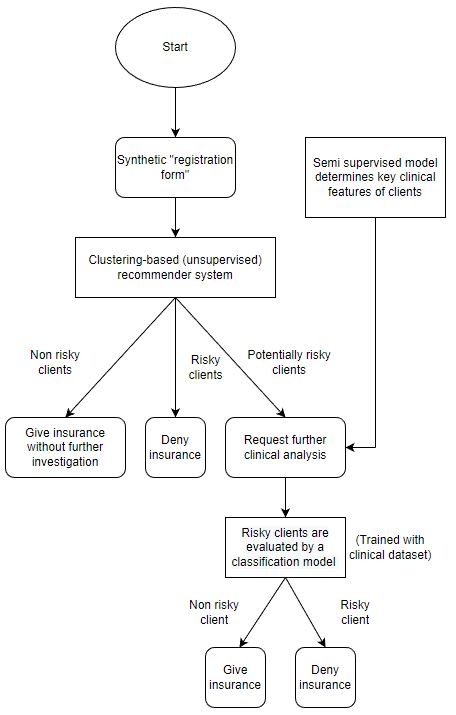

In [1]:
# Imports used in this Notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
import time
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import warnings
from scipy import stats
from sklearn import tree
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Perceptron
from sklearn.model_selection import KFold
from sklearn.cluster import KMeans
import random

from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, matthews_corrcoef

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from faker import Faker

import warnings
warnings.filterwarnings("ignore")

___
# Registration form

> In this section, we will explore problems _(1.1)_ and _(1.2)_, meaning, the clustering and classification of answers in the registration form. The lack of a dataset implies the need for the creation of a synthetic one.

## Synthetic dataset creation

Methodologically, the creation of a dataset presents a problem, since such creation could have as an input the very same model that we wish to apply. For example, in Scikit-learn's data generator implementation, one must describe the problem one will address: if a clustering or classification model is desired, then one would use $make__blobs$ or $make__classification$. This places a huge challenge due to the fact that one is creating the problem one wants to solve. In an unsupervised learning context, this problem worsenes, since we are imposing the dataset the very same patterns and probability distributions that we are eager to discover.

Since we desire to run both a clustering model and the a classificator, we will create the dataset manually. We understand that more complex and precise approaches can be performed, but for technical and time-based reasons we decide to take this step.

The attributes for each sample must be related to the questions in the registration form: 
- Weight (float) 
- Height (float)
- Number of sports practiced (int)
- Smoker (bool)
- Risky activity (bool)
- Hipertension (bool)
- Diseases (bool)
- Treatments (bool)

For the means and standard deviations of each feature, we followed the US National Census Bureau data.

The way the dataset is constructed can be said to pre-suppose certain clusters, in particular, in the "if smoker" reasoning. However, we attempt to relate all variables, meaning, the probability of being a smoker depends on the probability of being a sports-person, but hypertension depends on both. This variable inter-twining complexes the problem and makes it a higher challenge than just simply randomizing variables each with its own independent distribution.

### Data analysis on synthetic dataset

#### Dataset configuration

In [2]:
regform_df = pd.read_csv('reg_form.csv')

# Printing head: variable identification
regform_df.head()

,name,weight,height,number_of_sports,smoker,risky_activity,hypertension,health_concerns,past_treatments
0,Patrick Hopkins,48,163,1,0,1,0,0,0
1,Brian Davis,73,165,1,0,0,1,1,1
2,Hunter Williams,66,180,0,0,0,1,0,0
3,Heather Ford,99,183,1,0,0,0,0,1
4,Ronnie Kim,92,147,3,0,0,0,1,0


In [3]:
# Size
regform_df.shape

(1000, 9)

In [4]:
# Statistical properties
regform_df.describe(percentiles = [0.25, 0.50, 0.75, 0.95])

,weight,height,number_of_sports,smoker,risky_activity,hypertension,health_concerns,past_treatments
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.0000,1000.000000,1000.00000
mean,88.519000,175.467000,1.634000,0.155000,0.431000,0.2610,0.199000,0.25600
std,21.024835,19.618098,0.998519,0.362086,0.495464,0.4394,0.399448,0.43664
min,9.000000,104.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.00000
25%,76.000000,163.000000,1.000000,0.000000,0.000000,0.0000,0.000000,0.00000
50%,90.000000,175.000000,1.000000,0.000000,0.000000,0.0000,0.000000,0.00000
75%,103.000000,188.000000,3.000000,0.000000,1.000000,1.0000,0.000000,1.00000
95%,122.000000,209.050000,3.000000,1.000000,1.000000,1.0000,1.000000,1.00000
max,163.000000,232.000000,3.000000,1.000000,1.000000,1.0000,1.000000,1.00000


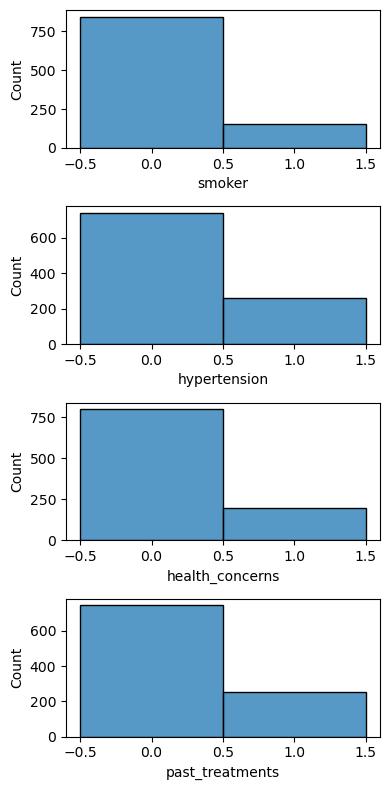

In [5]:
# Histograms
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize=(4, 8))
sns.histplot(regform_df['smoker'], discrete=True, ax=ax1)
sns.histplot(regform_df['hypertension'], discrete=True, ax=ax2)
sns.histplot(regform_df['health_concerns'], discrete=True, ax=ax3)
sns.histplot(regform_df['past_treatments'], discrete=True, ax=ax4)
plt.tight_layout()

Two things can be said from these plots:

- The fact that we chose to plot the given features implies our tendency to ponder these features as important for the future clustering and classification models. We can only assume that these features are importants for __our__ mind-made clustering, but cannot ensure that the clustering will actually follow the behaviour of these features.

- We can see that the key features we guess that would tend to ask a client further information, are in low proportions to the whole population. This, we believe, is logical: the cases in which further data is asked should not be higher than the classical registration process. These clients should be exceptions, not the rule; this however, does not contradict our approach of preferring to classify someone negatively over positively.

#### Data cleaning and pre-processing

In [6]:
# Null counts is obviously zero (we could have added randomic NaNs)

In [7]:
# Pre-processing
regform_df_clustering = regform_df.loc[:, regform_df.columns != 'name']
regform_df_clustering.head()

,weight,height,number_of_sports,smoker,risky_activity,hypertension,health_concerns,past_treatments
0,48,163,1,0,1,0,0,0
1,73,165,1,0,0,1,1,1
2,66,180,0,0,0,1,0,0
3,99,183,1,0,0,0,0,1
4,92,147,3,0,0,0,1,0


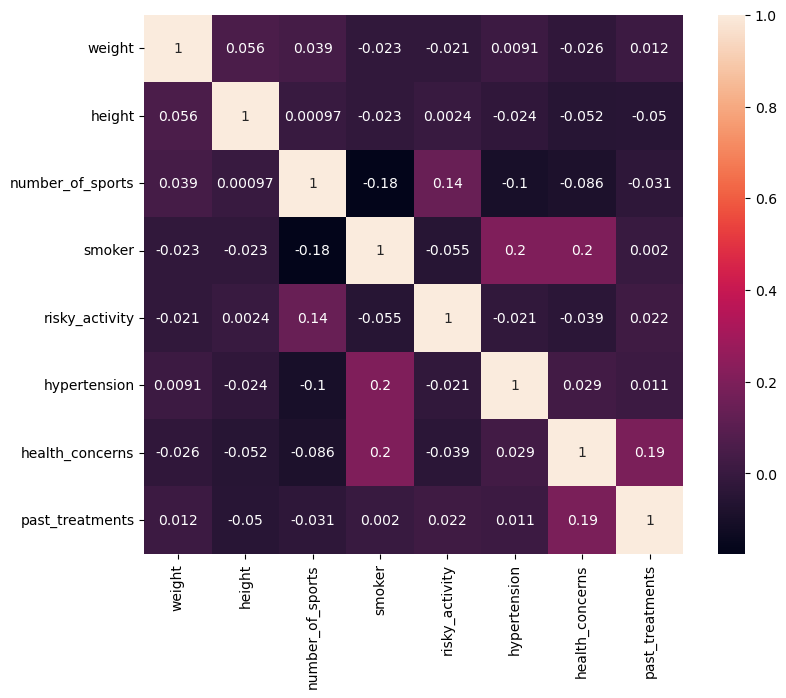

In [8]:
# Observing relationships between variables
f, ax = plt.subplots(figsize=(9, 7))
correlation_regform = regform_df_clustering.corr()
sns.heatmap(correlation_regform, mask=np.zeros_like(correlation_regform, dtype=bool), square=True, ax=ax, annot=True)
plt.show()

It is surprisingly interesting that some correlations are as desired:
- One would expect, however, a higher correlation between weight and height, but there seems to be a relation between them (compared to other coefficients, at least).
- Smoking is negatively correlated to sports, as imposed and desired, but positively correlated with hypertension and health concerns.
- Risky activity with sports, as well as smoker with sports (negatively), are the highest correlations.

A fruitful investigation could be the impact of imposed probabilities on the correlation matrix. Although some dim correlations are found (and they are the desired correlations), we could have changec probabilities as to strengthen some relationships between features.

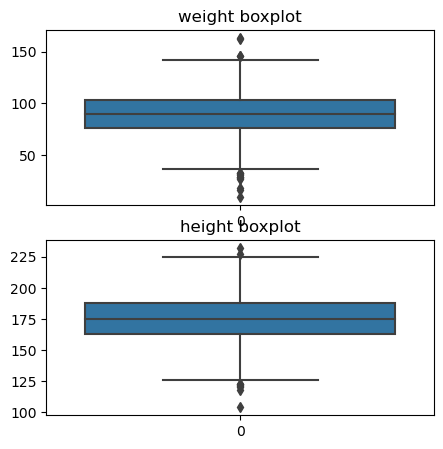

In [9]:
# Boxplots for outlier identification in non-binary features
fig, (ax1, ax2) = plt.subplots(2, figsize = (5,5))
sns.boxplot(regform_df_clustering['weight'], ax=ax1)
ax1.title.set_text('weight boxplot')
sns.boxplot(regform_df_clustering['height'], ax=ax2)
ax2.title.set_text('height boxplot')

In [10]:
# Outlier considerations
regform_df_clustering = regform_df_clustering[regform_df_clustering['weight'] > 45]
regform_df_clustering = regform_df_clustering[regform_df_clustering['height'] > 125]
regform_df_clustering.shape

(967, 8)

We took out a total of 33 outliers.

#### Dataset discussion

As it was already mentioned, the great challenge of a synthetic dataset is the artificial creation of relationships between variables; relationships that will then be the output of the different models. After all, the bedrock of data analysis are shared behaviours among features. In certain sense, we are 

In order to analyze the dataset's properties, we will frame the discussion into categories:
- __Volume:__ We can impose the dataset size. Number of columns is directly linked to the number of questions in the registration form. By the law of great numbers, a huge dataset would reflect the exact probabilities we set in the dataset creation; we need to randomize (by setting a not-so-high dataset size) since we acknowledge that the imposed relationships and probabilities could not be the real ones. We took a _common-sense approach_.
- __Velocity:__ This aspect is not of interest in this deliverable (we are __not__ getting data faster than we can process it).
- __Variety:__ The normal distributions and binary character of most of the features restrict the discussion on variety.
- __Veracity:__ This is the key issue in question: how do we prove our dataset's validity in terms of its truth value? What can our dataset say about reality? The synthetic creation implies that we cannot really know this unless we have a real dataset to which we can compare, or at least a few samples.
- __Value:__ The business value of the dataset could be put in terms of supply and demand: the lack of a real dataset highly monetizes this synthetic one.

## Clustering model

In [11]:
def elbow_method(max_clusters, dataset):
    # Elbow method

    elbow_points = []
    #max_clusters = len(dataset_blood_scaled)
    n_clust = [i+2 for i in range(max_clusters)]

    for num in n_clust:
        kmeans = KMeans(n_clusters = num, random_state = 42)
        kmeans.fit(dataset)
        elbow_points.append(kmeans.inertia_)

    plt.plot(n_clust, elbow_points, 'bo-')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    plt.show()

In [12]:
# Performing the elbow method in order to determine optimal number of clusters (based on inertia)
max_clusters = 10
scaler = StandardScaler() 
regform_scaled = pd.DataFrame(scaler.fit_transform(regform_df_clustering), columns = regform_df_clustering.columns)

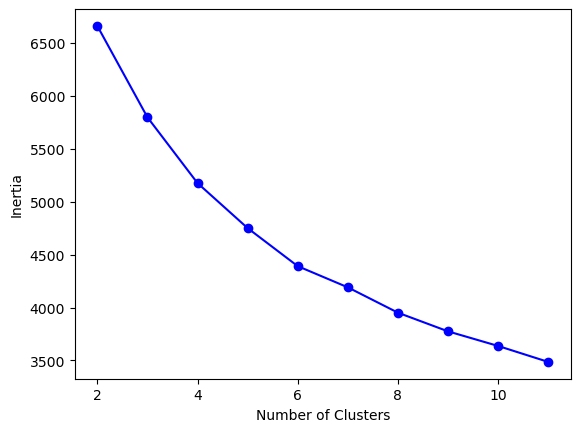

In [13]:
elbow_method(max_clusters, regform_scaled)

Optimal number of clusters could be argued to be 5. For the sake of simplicity, we shall choose 4 clusters. 

In [14]:
def nClusters(n, dataset):
    
    # DESCRIPTION: 
    # Function that clusterizes some dataset.
    
    # INPUTS:
    # n (int): Number of clusters
    # dataset (pd Dataframe): Clients dataset after a PCA for dimensionality reduction
    # modelType (str): string indicating the choice of model
    
    # OUTPUTS:
    # model (object): the sklearn model of kmeans already "trained", used for
    # obtaining information
    # dataset (pd dataframe): the fitted dataset
    # clusters_df (pandas dataframe): the input dataframe but with cluster id aggregated
    # assign (pandas dataframe): the original first dataframe with original features,
    # but with cluster id aggregated
    
    model = KMeans(n_clusters = n, random_state = 42) # max iters is set to 300 by default
    model.fit(dataset)

    # Assign a cluster id to the original df.
    clusters_df = pd.concat([dataset, pd.Series(model.labels_)], axis = 1) # concatenate labels to pca df
    clusters_df.columns = np.concatenate((dataset.columns.values, ['CLUSTER ID']), axis = 0) #add the "cluster id" columna
    #clusters_df = pd.concat([CUST_ID, clusters_df], axis = 1) #add the "customer id" df at the begining.
    print(f'The model assigned these values:')
        
    # Recovering previous features for discussion:
    #assign = pd.concat([client_data, pd.Series(model.labels_)], axis = 1) # concatenate labels to pca df
    #assign.columns  = np.concatenate((client_data.columns.values, ['CLUSTER ID']), axis = 0) #add the "cluster id" columna
    print(clusters_df['CLUSTER ID'].value_counts())
        
    return clusters_df, model

In [15]:
n_clusters = 4 # chosen by looking at the elbow curve

regform_scaled_clusters, kmeans_model = nClusters(n_clusters, regform_scaled)

The model assigned these values:
1    336
2    271
0    211
3    149
Name: CLUSTER ID, dtype: int64


In [16]:
regform_df_clustering.fillna(0) # for safety issues

# Adding the "cluster id" column to the original registration form dataset, in order to get statistics. 
# (The clustering is performed on a scaled version of the dataset)
regform_df_clustering['CLUSTER ID'] = regform_scaled_clusters['CLUSTER ID'].values.astype(int)
regform_df_clustering.head()

,weight,height,number_of_sports,smoker,risky_activity,hypertension,health_concerns,past_treatments,CLUSTER ID
0,48,163,1,0,1,0,0,0,2
1,73,165,1,0,0,1,1,1,0
2,66,180,0,0,0,1,0,0,1
3,99,183,1,0,0,0,0,1,0
4,92,147,3,0,0,0,1,0,1


We will plot these 8-dimensional clusters onto a 2-dimensional and 3-dimensional spaces, in order to visually see their meaning.

In [17]:
def plotNdimensions(n,n_clusters, dataset,model, model_type): 
 
    
    # DESCRIPTION:
    # Function that given a fitted dataset, plots the clustering result
    # in order to do this, we perform a PCA to reduce dimensionality.
    
    # INPUTS:
    # n (int): number of dimensions to plot (number of components of visualization PCA)
    # dataset (sklearn object): ALREADY fitted dataset of 6 components
    # model (sklearn object): model type, only used to get labels for plot
    # model_type (str): string indicating the model type,
    # only used for fancy automatic titles
    
    # OUTPUTS:
    # No outputs
    
    plt.rcParams['figure.figsize'] = [10, 7]
    
    # pca to lower dimension to n
    n_components = n
    pca_final = PCA(n_components = n_components)
    pca_final.fit(dataset)  
    
    # aux df for plotting
    visualization = pd.DataFrame(pca_final.fit_transform(dataset), columns = [str(i) for i in range(n)])
    visualization = pd.concat([visualization, pd.Series(model.labels_)], axis = 1) # add the labels
    visualization.columns = np.concatenate(([str(i+1) for i in range(n)],['CLUSTER ID']), axis = 0)   
    
    if n == 3:
        fig = plt.figure()
        ax = fig.add_subplot(projection='3d')
        x = visualization['1'].values.astype(float)
        y = visualization['2'].values.astype(float)
        z = visualization['3'].values.astype(float)

        ax.scatter(x,y,z, c=visualization["CLUSTER ID"], s=40) #, cmap="RdBu")
        
        plt.title(f'3D visualization for: {n_clusters} clusters, using: {model_type} clustering')
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        ax.set_zticklabels([])
        
        ax.set_xlabel('PC1', fontweight ='bold')
        ax.set_ylabel('PC2', fontweight ='bold')
        ax.set_zlabel('PC3', fontweight ='bold')
      
        plt.show()
    
    elif n == 2:
        
        sns.scatterplot(x='1',y='2',hue='CLUSTER ID',legend='full',data=visualization).set(title=f'2D visualization for: {n_clusters} clusters, using: {model_type} clustering')

    else:
        print("The human brain can only interpret 2 or 3 dimensions")
        
        

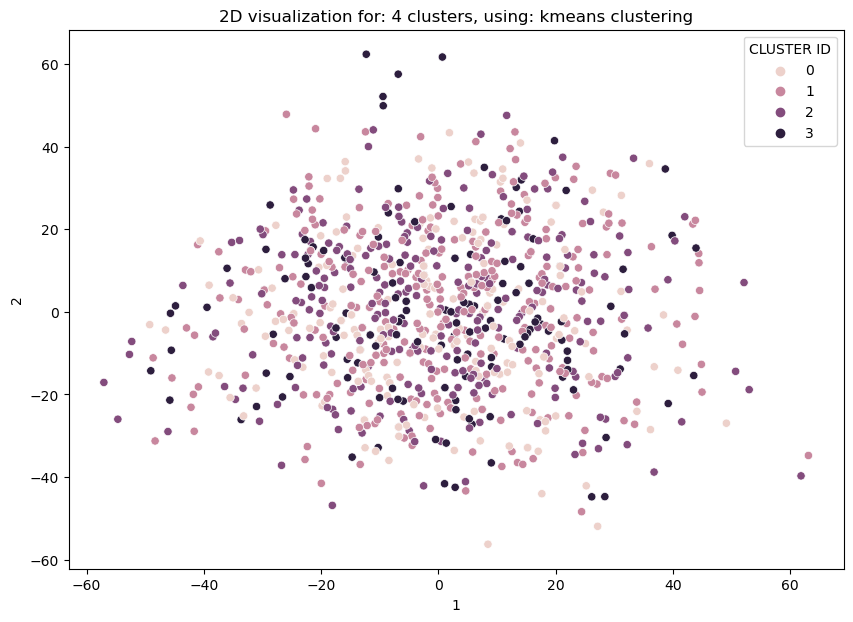

In [19]:
dimensions = 2
plotNdimensions(dimensions,n_clusters, regform_df_clustering, kmeans_model, 'kmeans')

Not much information can be obtained with a 2d visualization. 

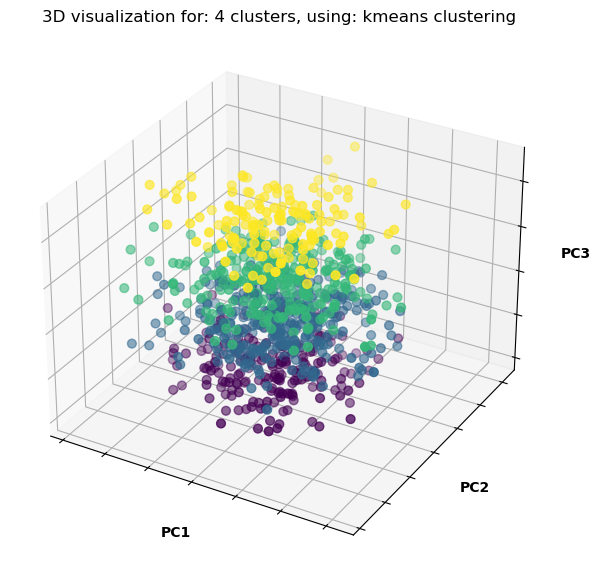

In [20]:
dimensions = 3
plotNdimensions(dimensions,n_clusters, regform_df_clustering, kmeans_model, 'kmeans')

We can see 4 distinct 8-dimensional clusters projected onto a 3-dimensional space: for example, the yellow cluster tends to have the highest PC3, whereas the purple one the lowest..


In the next cells, we will obtain statistics on these clusters. 

In [21]:
# function to get the means of every dimension (atribute) for each of the n clusters chosen.

def getMeansFromCluster(assigned_df, n_clusters):
    
    # DESCRIPTION:
    # Function that outputs statistics of dataset with assigned cluster id
    # after some clusterization
    
    # INPUTS:
    # assigned_df (pandas dataframe): dataframe containinng the original
    # features before pca and a cluster id
    # n_clusters (int): number of clusters 
    
    # OUTPUTS:
    # statistics (pandas dataframe): dataframe containing the mean of
    # every feature grouped by cluster
    
    # HAY QUE CAMBIAR ESTO
    #["weight", "height", "number of sports", "smoker", "risk activity", "hipertension", "diseases", "treatements"]
    
    weight = pd.DataFrame(assigned_df.groupby(['CLUSTER ID']).weight.mean())
    height= pd.DataFrame(assigned_df.groupby(['CLUSTER ID']).height.mean())
    sports= pd.DataFrame(assigned_df.groupby(['CLUSTER ID']).number_of_sports.mean())
    smoker = pd.DataFrame(assigned_df.groupby(['CLUSTER ID']).smoker.mean())
    risk_activity = pd.DataFrame(assigned_df.groupby(['CLUSTER ID']).risky_activity.mean())
    hipertension = pd.DataFrame(assigned_df.groupby(['CLUSTER ID']).hypertension.mean())
    diseases = pd.DataFrame(assigned_df.groupby(['CLUSTER ID']).health_concerns.mean())
    treatements = pd.DataFrame(assigned_df.groupby(['CLUSTER ID']).past_treatments.mean()) 
    

    statistics = pd.concat([pd.Series([i for i in range(n_clusters)]), weight,height, sports, smoker,risk_activity,hipertension,diseases,treatements], axis=1)
    statistics = statistics.rename(columns = {0:'CLUSTER ID'}) #correct the number of cluster id column
    return statistics


In [22]:
statistics = getMeansFromCluster(regform_df_clustering, n_clusters)
statistics

,CLUSTER ID,weight,height,number_of_sports,smoker,risky_activity,hypertension,health_concerns,past_treatments
0,0,89.862559,174.099526,1.644550,0.0,0.454976,0.251185,0.289100,1.000000
1,1,90.970238,176.854167,1.625000,0.0,0.000000,0.211310,0.122024,0.000000
2,2,89.649446,176.752768,1.892989,0.0,1.000000,0.202952,0.118081,0.000000
3,3,89.093960,175.845638,1.255034,1.0,0.362416,0.476510,0.395973,0.255034


### Clustering analysis

> * _Cluster 0:_ These clients do __not smoke__, practise on average __$\geq 1$ sports__ but have some degree of hypertension and health concerns, plus some past treatments. We shall __request further clinical records__ on these clients, in order to fully determine if they are deemed safe to give insurance to.

> * _Cluster 1:_  These clientes do not smoke, practise sports, do not engage into any risky activity, have some degree of hypertension and low degree of health concerns and no past tratments. We shall give out the __insurance without further clinical records__

> * _Cluster 2:_ The clients that fall into this category have a mean of $1$ risky activity, meaning, they _all_ engage in hazardous activities. These clients will have their __insurance denied__. However, this should be discussed alongside the insurance provider (maybe another life insurance product could be negotiated), but our model will take this approach. 

> * _Cluster 3:_ The clients in this group are smokers, 36% of them practice risky activities and 47% of them present hypertension, 39% of them have health concerns and 25% of them recived past treatments. We could deny the insurance or we could opt to request furhter clinical records. We shall __request further clinical records__ on these clients.

Something that is hopeful in this clustering is the fact that neither mean weight or height differ greatly from cluster to cluster, implying that the underlying criteria behind the grouping are not those features (as desired). 

We should again highlight the ethical implications of denying insurance to people in Cluster 2 solely based on their involvement with risky activity; in fact, the dataset creation specifies that, if the person is a "Construction Worker" or "Police Officer", risky activity is set to 1.  It is interesting also to note how the clustering provided a cluster with a cluster whose risky_activity is all 1, meaning, in the dataset creation, risky_activity turned out to be a decisive pathway into the different relationships between variables.

In [23]:
# We create a dataset of clients would have been requested
people_to_request = regform_df_clustering[regform_df_clustering['CLUSTER ID'].isin([0,3]) ]
people_to_request.reset_index(inplace = True)
people_to_request.head()

,index,weight,height,number_of_sports,smoker,risky_activity,hypertension,health_concerns,past_treatments,CLUSTER ID
0,1,73,165,1,0,0,1,1,1,0
1,3,99,183,1,0,0,0,0,1,0
2,5,97,179,3,0,0,0,0,1,0
3,11,73,188,1,1,0,1,0,0,3
4,13,88,165,1,0,0,0,1,1,0


In [24]:
print("Number of people that would have been requested further clinical analysis: ", len(people_to_request))

Number of people that would have been requested further clinical analysis:  360


### Conclusions on clustering model

By performing clustering-based methods to analyze the registration form dataset, we conclude that any client that falls into the $0$ or $1$ will be asked to give furhter clinical records. Let's remember that the clustering is based upon past registration form answers, meaning, people who have asked for life insurance in the past. These people were "wrongly" labelled as good or bad clients by rejecting their request for insurance or not. This, in fact, is an interesting use case for a clustering method: analyze the extent to which a past policy is adequate. What we are currently doing is exploring whether the past rejections were 

The fact that the final number of people that would have been requested further clinical analysis is near 30% of the total population is a coherent number. One could not expect this number to be greater than 50%, that would mean that the clinical records request would be the "rule", and not the "exception". As well, 30% is benefitial since, of all that 30%, not everyone would have been eventually accepted into the system due to their clinical records. Say, for example, a 60%-40% reject-accept ratio in this latter classification; then we would be talking about 12% of the past people should have been accepted. It is a number that is coherent with the mission of the task, which was to capture clients that were wrongly denied, but clients that were wrongly denied cannot be majority of those denied (unless the past policy was too poor). What we aim to say is that __clustering provides results in a proper order of magnitude__.

For the next sections, we shall train and test some clasiffication methods, using the clinical records dataset, in order to determine which of these clients will have their insurance denied or accepted. 


## Classification model

> The classes of the classification are the clusters from the previous clustering. It is only fair to base this classification in the very same clustering model that was used: thus, we take the k-means.predict() method implementation of Scikit-learn. It is interesting to note the inter-twining between the problems of clustering and classification, and this mixing extends to the point that a clustering model (k-means) has a classification-related method (.predict). Just as an example, we will run how this classification would work; we leave for future research the inquiry on the metrics of this classification model in particular.

In [47]:
# Create a new person
fake = Faker()
name = fake.name()
height = round(np.random.normal(175, 20))
weight = round(np.random.normal(75, 25))
sports = random.choices([0, 1, 2, 3], [0.3, 0.3, 0.2, 0.2])[0]

if height > 195*np.random.random():  # if too tall, maybe plays basketball and more sports
    weight = round(np.random.normal(90, 20))
    sports = random.choices([0, 1, 2, 3], [0.1, 0.4, 0.25, 0.25])[0]

if sports > 2.5*np.random.random():  # randomize logic behind relationships in the dataset
    smoker = random.choices([0, 1], [0.95, 0.05])[0]  # if sports-person, more unlikely to smoke than not sports-person
    risky_habit = random.choices([0, 1], [0.5, 0.5])[0]  # if too many sports, more likely to have a risky sport
else:
    smoker = random.choices([0, 1], [0.75, 0.25])[0]
    risky_habit = random.choices([0, 1], [0.7, 0.3])[0]
    
job = fake.job()
if job in ['Construction worker', 'Police officer', 'Firefighter']:  
    # it is interesting to note the ethical implications of this code line
    risky_habit = 1

if smoker: # smokers
    hypertension = random.choices([0, 1], [0.6, 0.4])[0]
    health_concern = random.choices([0, 1], [0.65, 0.35])[0]
elif sports > 2*np.random.random(): # "sportsperson"
    hypertension = random.choices([0, 1], [0.8, 0.2])[0]
    health_concern = random.choices([0,1], [0.85, 0.15])[0]
else: # "normal" person
    hypertension = random.choices([0, 1], [0.7, 0.3])[0]
    health_concern = random.choices([0, 1], [0.75, 0.25])[0]

if health_concern:
    past_treatment = random.choices([0, 1], [0.6, 0.4])[0]
else:
    past_treatment = random.choices([0, 1], [0.8, 0.2])[0]

new_person_data = [name, weight, height, sports, smoker, risky_habit, hypertension, health_concern, past_treatment]
new_person_columns =  ["name", "weight", "height", "number_of_sports", "smoker", "risky_activity", "hypertension", "health_concerns", "past_treatments"]
new_person_dict = dict(zip(new_person_columns, new_person_data))
new_person_df = pd.DataFrame(new_person_dict, index=[0])
new_person_df.head()

,name,weight,height,number_of_sports,smoker,risky_activity,hypertension,health_concerns,past_treatments
0,David Mann,116,190,1,1,0,0,0,0


In [48]:
# Sample classification
preprocessed_new_person = new_person_df.loc[:, new_person_df.columns != 'name']
cluster_new = kmeans_model.predict(preprocessed_new_person)
print('New person belongs to Cluster', cluster_new[0])

New person belongs to Cluster 1


___
# Clinical records information

> We now turn into problem _(2)_, which aims to identify key patterns in a clinical records dataset as to create a predictive model over incoming clients' clinical information; the objective is to identify heart failure risk. __We perform both a decision tree and a random forest as to understand which health variables are to be asked; then, we make use of these decision tree and random forest as to perform the classification model with the help of other algorithms as well.__ 


## Data analysis on clinical records dataset

### Dataset configuration

In [ ]:
# Dataset
dataset_blood = pd.read_csv('heart_failure_clinical_records_dataset.csv')

# Variable identification: dataset format with first sample bloodtests
dataset_blood.head()

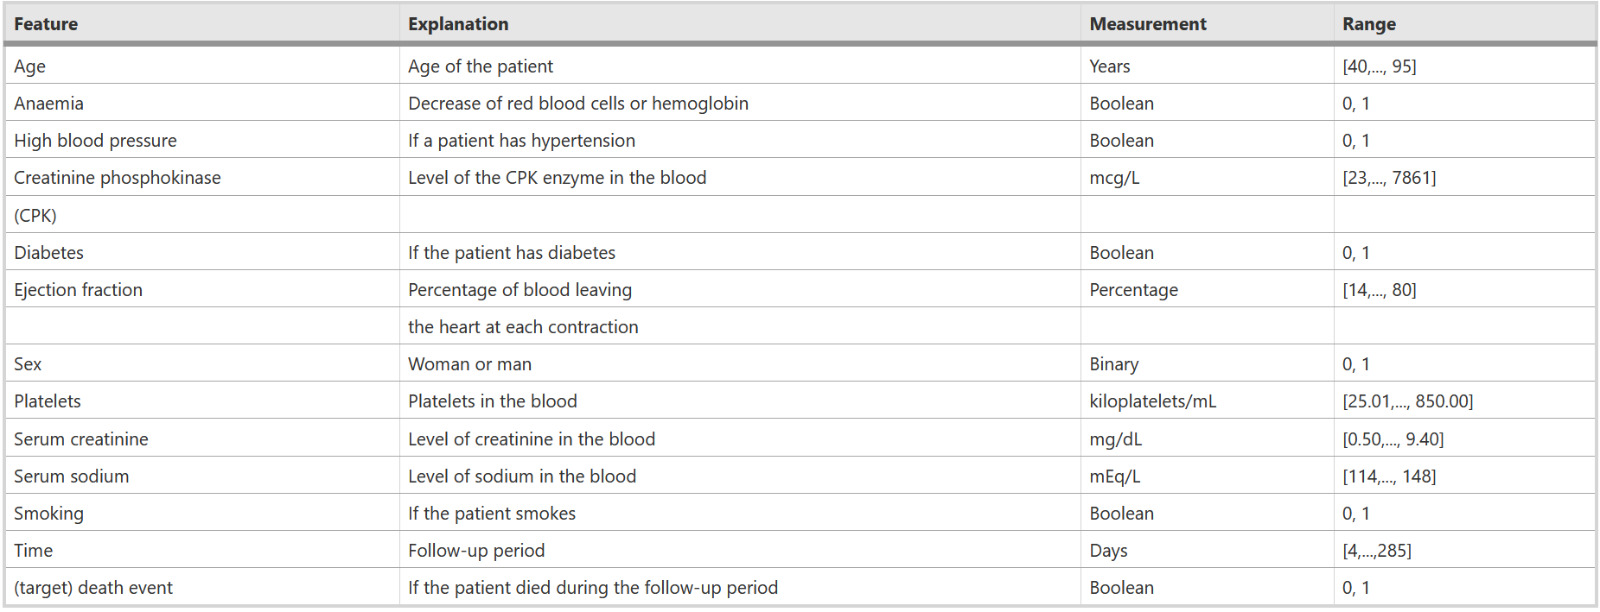

In [ ]:
# Print dataset size
dataset_blood.shape

In [ ]:
# Data types and null counts
dataset_blood.info()

It should be noted how non-null counts are all equal to the amount of samples in the dataset: there are no null values.

In [ ]:
# Statistical properties
dataset_blood.describe(percentiles = [0.25, 0.50, 0.75, 0.95])

This presentation of statistical properties indicates the need for outlier considerations: for example, the maximum value in _creatinine_phosphokinase_ is too high compared to the mean, the standard deviation and the 95% percentile. The same happens with _platelets_ and _serum_creatinine_.

In [ ]:
# Histogram of counts
fig, ax = plt.subplots(figsize=(4, 4))
sns.histplot(dataset_blood['DEATH_EVENT'], discrete=True)
print(pd.concat( [dataset_blood['DEATH_EVENT'].value_counts(),
                  dataset_blood['DEATH_EVENT'].value_counts(normalize=True).mul(100).round(2)],
                 axis = 1,
                 keys = ('Count', 'Percentage')))

We can observe that the dataset is highly unbalanced towards "no death event". Nevertheless, medical conditions such as heart failure cannot be expected to be balanced: it is as if we were looking into the diabetes feature and desire to have a balanced population of 50%-50%.

### Data cleaning and pre-processing

In [ ]:
# Cleaning unwanted features
dataset_blood.drop('time', axis=1, inplace=True)
dataset_blood.shape

Given a description of all variables, we understand that the feature _Time_ is not relevant for the analysis; we were not going to consider cases where follow-up period is either too short or too long, but dataset was drastically reduced and those extreme situations carried information (for example, short follow-ups coincided with death event, and viceversa). Thus, we chose to __eliminate__ the _Time_ feature for our models, in order to minimize possible bias and to not fall into the "correlation does not imply causation" mistake

In [ ]:
# Confirmation on null counts
dataset_blood.isnull().sum()

In [ ]:
# Observing relationships between variables
f, ax = plt.subplots(figsize=(9, 7))
correlation = dataset_blood.corr()
sns.heatmap(correlation, mask=np.zeros_like(correlation, dtype=bool), square=True, ax=ax, annot=True)
plt.show()

Variables do not seem to be highly correlated between each other: the maximum correlation, in absolute value, is 0.5. This suggests that the feature combinations do not overlap (each feature would add valuable information), possibly implying a low degree of reduction in explained variance in a PCA analysis.

In [ ]:
# Explained variance reducing dimensionality
scaler = MinMaxScaler() 
exp_var_dataset_blood_scaled = pd.DataFrame(scaler.fit_transform(dataset_blood), columns = dataset_blood.columns)

pca = PCA()
pca.fit(exp_var_dataset_blood_scaled)
figure_, ax = plt.subplots(figsize=(5, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), 'bo-')
plt.xlabel('Dimensionality')
plt.ylabel('Cumulative Explained Variance')
plt.show()

The assumption derived from the correlation matrix turned out to be rather untrue, given the fact that a 6-dimensional space would explain 95% of variance. This could be understood by the fact that the correlation matrix does not include correlation between combinations of variables. Nevertheless, __we will not perform PCA since we want to maintain the white-box nature of the modelling__ and maneuver variables with clinical sense.

In [ ]:
# Boxplots for outlier identification in relevant columns
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, figsize = (10,10))
sns.boxplot(dataset_blood['creatinine_phosphokinase'], ax=ax1)
ax1.title.set_text('creatinine_phosphokinase boxplot')
sns.boxplot(dataset_blood['ejection_fraction'], ax=ax2)
ax2.title.set_text('ejection_fraction boxplot')
sns.boxplot(dataset_blood['platelets'], ax=ax3)
ax3.title.set_text('platelets boxplot')
sns.boxplot(dataset_blood['serum_creatinine'], ax=ax4)
ax4.title.set_text('serum_creatinine boxplot')
sns.boxplot(dataset_blood['serum_sodium'], ax=ax5)
ax5.title.set_text('serum_sodium boxplot')
warnings.filterwarnings("ignore", category=FutureWarning)

In [ ]:
# Outlier considerations
dataset_blood = dataset_blood[(np.abs(stats.zscore(dataset_blood)) < 3).all(axis=1)]
dataset_blood.shape

We search for outliers in columns that seem relevant when looking at the dataframe.describe() method. We can observe the high degree of outliers; thus, we take a brute force approach (instead of finger-picking outliers), and take out outliers with the traditional definition of samples 3 or more times the standard deviations far from the mean.

### Dataset discussion

In order to analyze the dataset's properties, we will frame the discussion into categories:
- __Volume:__ Interestingly enough, one would think that more data is available for such a relevant topic. However, it is understood that with medical information data can be scarce, and this is definetely the case.
- __Velocity:__ This aspect is not of interest in this deliverable (we are __not__ getting data faster than we can process it).
- __Variety:__ The high degree of outliers can in fact be proof of the varied nature of the dataset.
- __Veracity:__ Lack of null values and lack of incoherent data samples makes a good case for this dataset's veracity.
- __Value:__ The business value of the dataset is framed in the insurance client policy system, although its scope reaches far from this application only.

## Key clinical variables

> We will now try to identify the most important features that determine the risk of heart failure by implementing both a decision tree and a random forest, and comparing feature importance in each case.

Since the exploration of the most important clinical variables is a different problem to the future classification mode, we consider that it is fair to treat them separately and perform a train/test split for each one. We thought of "recycling" decision trees and random forests that will be produced in this section for the following one: instead, we need to clarify that this usage of trees and forests is more a ___semi-supervised learning___ instance (_as a dataset comprehension mechanism_), whereas the classification model's usage of trees and forest is definetely a __supervised learning__ context. The nature of the problems are different; thus again, we treat them separately.

In [ ]:
# Scaling dataset for all next cells
scaler = MinMaxScaler() 
dataset_blood_scaled = pd.DataFrame(scaler.fit_transform(dataset_blood), columns = dataset_blood.columns)

In [ ]:
# Train and test split for the analysis of key clinical variables
X_key = dataset_blood_scaled.loc[:,dataset_blood_scaled.columns != 'DEATH_EVENT'] # features
y_key = dataset_blood_scaled ['DEATH_EVENT'] # target variable

X_train_key, X_test_key, y_train_key, y_test_key = train_test_split(X_key, y_key, stratify = y_key, random_state = 42) # stratify on y

In [ ]:
# Function to plot important features in a tree/forest model
def plot_feature_importances(model, figure):

    n_features = len(X_key.columns) # number of features
    plt.figure(figsize=(5,5))
    plt.barh(range(n_features), model.feature_importances_, align='center') # check documentation on model
    plt.yticks(np.arange(n_features), X_key,size=10)
    plt.xticks(size=8)
    plt.xlabel('Feature importance',size=10)
    plt.ylabel('Features',size=10)
    plt.ylim(-1, n_features)
    sns.despine(top=True)
    plt.title(f'{figure}',size=10)
    plt.tight_layout()

### Decision tree for key variables

In this section, we will train two tree models, but we will not use them to clasify. Instead, we will use them to determine which clinical features are most important. __This is the "semi supervized" model referenced on the flowchart__

In [ ]:
# Plot accuracy score for different tree depths
max_depth=range(1,20)
training_accuracy_key = [] 
test_accuracy_key = []

for depth in max_depth : 

    tree_depth = DecisionTreeClassifier(random_state=42, max_depth=depth, min_samples_leaf=1).fit(X_train_key, y_train_key)

    y_train_pred_key = tree_depth.predict(X_train_key)
    y_pred_key = tree_depth.predict(X_test_key)

    training_accuracy_key.append(accuracy_score(y_train_key,y_train_pred_key))
    test_accuracy_key.append(accuracy_score(y_test_key, y_pred_key))

fig = plt.figure(figsize=(12,10))
fig.subplots_adjust(hspace=0.5, wspace=0.3)

fig.add_subplot(2,2,1)
plt.plot(max_depth, training_accuracy_key, label='Training accuracy')
plt.plot(max_depth, test_accuracy_key, label='Test accuracy')
plt.ylabel('Accuracy',size=10)
plt.xlabel('Max depth',size=10)
plt.xticks(size=15)
plt.yticks(size=15)
plt.title('Accuracy Score',size=10, weight='bold')
plt.legend(['Training','Testing'],frameon=False)
plt.show()    

As expected, the accuracy of training quickly tends to $1$ as the max depth increases. This is due to the very definition of overfitting a tree. We see a maximum of accuracy on training to max depth = 3

Furthermore, because there is a small amount of data samples, the tree quickly tends towards overfitting. This is evidenced by the sudden rise of the training accuracy, and the drop on the testing accuracy.

In [ ]:
# Decision Tree implementation
tree_key = DecisionTreeClassifier(max_depth=3, min_samples_leaf=1, random_state=42).fit(X_train_key, y_train_key)
y_pred_key = tree_key.predict(X_test_key)
tree_accuracy_key = accuracy_score(y_pred_key, y_test_key)

print("Accuracy on test: ",tree_accuracy_key)

In [ ]:
plot_feature_importances(tree_key,'Decision Tree')

In [ ]:
# Visualize tree
fig = plt.figure(figsize=(25,20))
tree.plot_tree(tree_key, feature_names=X_train_key.columns,  class_names=['0', '1'],filled=True)
plt.show()

The most important feature coincides with the first tree separator.

We shall repeat this process using random forest, in order to analyze more extensively and compare results: a decision tree can be biased to "over-ponder" the importance of a given feature. A random forest would cancel the bias of many trees to over-ponder or under-ponder certain features.

We shall not discuss metrics (for example, gini) on the nodes because we already plotted the __Feature importance__. Citing from the Sklearn.tree.DecisionTreeClassifier documentation: 

>_The importance of a feature is computed as the (normalized) total reduction of the criterion brought by that feature. It is also known as the Gini importance._

### Random forest for key variables


In [ ]:
rf_key = RandomForestClassifier(n_estimators=100, random_state=42).fit(X_train_key, y_train_key)
y_pred_key = rf_key.predict(X_test_key)
forest_accuracy = accuracy_score(y_pred_key, y_test_key)

print("Accuracy on test: ",forest_accuracy)

Both tree models give out an accuracy of aproximately 0.7, this is desired. It is fairly similar to the accuracy obtained in the paper _"Chicco, D., Jurman, G. Machine learning
can predict survival of patients with heart failure from serum creatinine and ejection
fraction alone"_

However, for know, we do not use this metric. Instead, we concern ourelves with the feature importance's plot.

In [ ]:
plot_feature_importances(rf_key, 'Random Forest')

### Key variables discussion

In [ ]:
def variable_stats(var, dataset, axis):
    sns.histplot(data = dataset, x = var, ax=axis)
    plt.xlabel(var)

In [ ]:
# Distributions of key features
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, figsize = (7,7))
variable_stats('serum_creatinine', dataset_blood, ax1)
variable_stats('ejection_fraction', dataset_blood, ax2)
variable_stats('creatinine_phosphokinase', dataset_blood, ax3)
variable_stats('age', dataset_blood, ax4)
variable_stats('platelets', dataset_blood, ax5)
warnings.filterwarnings("ignore", category=FutureWarning)
plt.tight_layout()

Both models give similar results on feature importance, but as expected, random forest gives more insight into new features. Accuracy prints are to understand the scope of these results and to verify correct model hyper-parameters in the case of the decision tree.

As we can see, the most important features, ordered, are:
> * serum_creatinine
> * ejection_fraction
> * age
> * creatinine_phosphokinase, platelets and serum_sodium

It should be noted that these results are coherent with those found at the paper: see https://bmcmedinformdecismak.biomedcentral.com/articles/10.1186/s12911-020-1023-5/tables/7.

Further exploration on this topic could be the implementation of a p-values test (Pearson correlation); the research paper also takes this into account. However, we are satisfied with this approach: the main two features coincide with the researchers.

## Classification model on clinical dataset

> In this section, we will explore the implementation of a predictive model on heart failure risk. We will run various models; new decision tree and random forest, as well as other models. This approach is based on the fact that we are dealing with a reduced dataset and the implementation of different algorithms can help cope with this situation.

In [ ]:
# Train and test split for the classification models
X = dataset_blood_scaled.loc[:,dataset_blood_scaled.columns != 'DEATH_EVENT'] # features
y = dataset_blood_scaled ['DEATH_EVENT'] # target variable

X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X, y, stratify = y, random_state = 65) # stratify on y

### Decision tree and random forest
Both a decision tree and a random forest were implemented as to identify key clinical features. We will remember these results.

In [ ]:
# New Decision Tree implementation
tree_class = DecisionTreeClassifier(max_depth=3, min_samples_leaf=1, random_state=42).fit(X_train_class, y_train_class)
y_pred_class_tree = tree_class.predict(X_test_class)
tree_class_accuracy = accuracy_score(y_test_class, y_pred_class_tree)
tree_class_mcc = matthews_corrcoef(y_test_class, y_pred_class_tree)
tree_recall = recall_score(y_test_class, y_pred_class_tree)

y_train_class_tree = tree_class.predict(X_train_class)
tree_train_accuracy = accuracy_score(y_train_class, y_train_class_tree)
tree_train_mcc = matthews_corrcoef(y_train_class, y_train_class_tree)

print("Tree Classifier Accuracy on Train split: ", round(tree_train_accuracy, 3))
print("Tree Classifier MCC on Train split: ", round(tree_train_mcc, 3))
print("Tree Classifier Accuracy on Test split: ", round(tree_class_accuracy, 3))
print("Tree Classifier MCC on Test split: ", round(tree_class_mcc, 3))
print("Tree Recall on Test split: ", round(tree_recall, 3))

In [ ]:
conf_tree = confusion_matrix(y_test_class, y_pred_class_tree)
disp = sklearn.metrics.ConfusionMatrixDisplay(conf_tree, display_labels = ['no risk', 'heart failure risk'])
disp.plot()
plt.title('Decision Tree Confusion Matrix')
plt.show()

Logically, the decision tree implemented here is very similar in terms of accuracy to the one implemented for identifying key clinical variables.

In [ ]:
rf_class = RandomForestClassifier(n_estimators=100, random_state=42).fit(X_train_class, y_train_class)
y_pred_class_forest = rf_class.predict(X_test_class)
forest_accuracy = accuracy_score(y_test_class, y_pred_class_forest)
forest_mcc = matthews_corrcoef(y_test_class, y_pred_class_forest)
y_train_class_forest = rf_class.predict(X_train_class)
rf_train_accuracy = accuracy_score(y_train_class, y_train_class_forest)
rf_train_mcc = matthews_corrcoef(y_train_class, y_train_class_forest)
rf_recall = recall_score(y_test_class, y_pred_class_forest)

print("Random Forest Classifier Accuracy on Train split: ", round(rf_train_accuracy, 3))
print("Random Forest Classifier MCC on Train split: ", round(rf_train_mcc, 3))
print("Random Forest Classifier Accuracy on Test split: ", round(forest_accuracy, 3))
print("Random Forest Classifier MCC on Test split: ", round(forest_mcc, 3))
print("Random Forest Recall on Test split: ", round(rf_recall, 3))

In [ ]:
conf_rf = confusion_matrix(y_test_class, y_pred_class_forest)
disp = sklearn.metrics.ConfusionMatrixDisplay(conf_rf, display_labels = ['no risk', 'heart failure risk'])
disp.plot()
plt.title('Random Forest Confusion Matrix')
plt.show()

Although these metrics are not so bad, trees and forests as classification models suffer from the reduced dataset size and dimensionality problems. The risk of overfitting is very present. The fact that the Random Forest adjusts perfectly to the training split, whereas in the Testing split metrics worsen, is a clear sign of __overfitting__.

Additionally, both the Random Forest and the Decision tree have more False Negatives (predicted no risk but had heart failure risk) than False Positives (predicted risk but there was no threat). This is exactly what needs to be prevented, since it would mean the operational cost would increase (the insurance company would have to pay more, instead of the case where FP > FN, where the company would be losing more clients). Of course, the idea is to increase the amount of clients, but at the same time, the integrity of the company should be preserved: if the guiding principle were "accept as much clients as possible", a brute-force approach would include all clients. It should be noted that this decision, in the real-world, would imply a discussion with the insurance company on the extent of this trade-off between lost clients and accepted risky clients.

All in all, we turn to new models.

### More classification methods

We __need__ new models. Thus, we make a new split, and implement various different algorithms.
It is useful to recall from the data analysis on clinical dataset that the best number of features to retain 90% of explained variance is 6. We will perform a PCA for these new models and try to gain a different perspective.

In [ ]:
# Preparation for new models
n_components = 6
pca_final = PCA(n_components = n_components)
pca_final.fit(X)
dataset_blood_scaled_pca = pd.DataFrame(pca_final.fit_transform(X), columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6'])

In [ ]:
# New train-test split for PCA
y_pca = y
X_pca =  dataset_blood_scaled_pca 
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y_pca, train_size=0.8, test_size=0.2, random_state=89)

#### SVM

While performing an SVM, the main disadvantage is losing the white-box nature of the problem configuration (the business could not explain to a client our policy criteria). We also make use of Cross-Validation method when performing the grid-search for the lookout to the best hyper-parameters.

##### Linear SVM

In [ ]:
# Used for obtaining optimal parameters
hyper_params =  {'gamma': [0.01, 0.001,0.0001],'C': [1, 10, 100]}

# Create object model
SVM_model = SVC(kernel="linear")

# Create grid-search object and input model and dictionary of parameters
folds = KFold(n_splits = 5, shuffle = True, random_state = 20)
grid_search = GridSearchCV(estimator = SVM_model, param_grid = hyper_params, scoring = "accuracy", cv = folds)

# Perform grid-search
t_grid1 = time.perf_counter()
print("tuning hiper-params...")
SVM_best_model_linear = grid_search.fit(X_train_pca, y_train_pca)
t_grid2 = time.perf_counter()
print(f'Grid-search took: {t_grid2-t_grid1} seconds')

# Recovering best hyper-parameters and score for SVM
best_hyperparams = grid_search.best_params_ 
best_score = grid_search.best_score_ 

print(f'Best hiper-params are: {best_hyperparams} with score: {best_score}')

In [ ]:
# Create model with best SVM hiper-params
LSVM_test_pred = SVM_best_model_linear.predict(X_test_pca)
LSVM_train_pred = SVM_best_model_linear.predict(X_train_pca)

LSVM_accuracy_train = accuracy_score(y_train_pca, LSVM_train_pred)
LSVM_mcc_train = matthews_corrcoef(y_train_pca, LSVM_train_pred)

LSVM_accuracy_test = accuracy_score(y_test_pca, LSVM_test_pred)
LSVM_mcc_test = matthews_corrcoef(y_test_pca, LSVM_test_pred)

LSVM_recall = recall_score(y_test_pca, LSVM_test_pred)

print("Linear SVM Accuracy on Train split: ", round(LSVM_accuracy_train, 3))
print("Linear SVM MCC on Train split: ", round(LSVM_mcc_train, 3))
print("Linear SVM Accuracy on Test split: ", round(LSVM_accuracy_test, 3))
print("Linear SVM MCC on Test split: ", round(LSVM_mcc_test, 3))
print("Linear SVM Recall on Test split: ", round(LSVM_recall, 3))

##### RBF SVM

In [ ]:
# Used for obtaining optimal parameters
hyper_params =  {'gamma': [0.01, 0.001,0.0001],'C': [1, 10, 100]}

# Create object model
SVM_model = SVC(kernel="rbf")

# Create grid-search object and input model and dictionary of parameters
folds = KFold(n_splits = 5, shuffle = True, random_state = 20)
grid_search = GridSearchCV(estimator = SVM_model, param_grid = hyper_params, scoring = "accuracy", cv = folds)

# Perform grid-search
t_grid1 = time.perf_counter()
print("tuning hiper-params...")
SVM_best_model_rbf = grid_search.fit(X_train_pca, y_train_pca)
t_grid2 = time.perf_counter()
print(f'Grid-search took: {t_grid2-t_grid1} seconds')

# Recovering best hyper-parameters and score for SVM
best_hyperparams = grid_search.best_params_ 
best_score = grid_search.best_score_ 

print(f'Best hiper-params are: {best_hyperparams} with score: {best_score}')

In [ ]:
# Create model with best SVM hiper-params
RSVM_test_pred = SVM_best_model_rbf.predict(X_test_pca)
RSVM_train_pred = SVM_best_model_rbf.predict(X_train_pca)

RSVM_accuracy_train = accuracy_score(y_train_pca, RSVM_train_pred)
RSVM_mcc_train = matthews_corrcoef(y_train_pca, RSVM_train_pred)

RSVM_accuracy_test = accuracy_score(y_test_pca, RSVM_test_pred)
RSVM_mcc_test = matthews_corrcoef(y_test_pca, RSVM_test_pred)
RSVM_recall = recall_score(y_test_pca, RSVM_test_pred)

print("RBF SVM Accuracy on Train split: ", round(RSVM_accuracy_train, 3))
print("RBF SVM MCC on Train split: ", round(RSVM_mcc_train, 3))
print("RBF SVM Accuracy on Test split: ", round(RSVM_accuracy_test, 3))
print("RBF SVM MCC on Test split: ", round(RSVM_mcc_test, 3))
print("RBF SVM Recall on Test split: ", round(RSVM_recall, 3))

This result is obviously surprising: the SVM has a very high accuracy, but MCC shows that there is not a high tendency to classify properly (it is useful to remember that the lowest metric in MCC is $-1$).

#### Logistic Regression

In [ ]:
logreg = LogisticRegression(solver='newton-cg').fit(X_train_pca, y_train_pca) #keeping C=1 a
y_train_log = logreg.predict(X_train_pca)
y_test_log = logreg.predict(X_test_pca)

log_accuracy_train = accuracy_score(y_train_pca, y_train_log)
log_mcc_train = matthews_corrcoef(y_train_pca, y_train_log)

log_accuracy_test = accuracy_score(y_test_pca, y_test_log)
log_mcc_test = matthews_corrcoef(y_test_pca, y_test_log)
log_recall = recall_score(y_test_pca, y_test_log)

print("Logistic Regression Accuracy on Train split: ", round(log_accuracy_train, 3))
print("Logistic Regression MCC on Train split: ", round(log_mcc_train, 3))
print("Logistic Regression Accuracy on Test split: ", round(log_accuracy_test, 3))
print("Logistic Regression MCC on Test split: ", round(log_mcc_test, 3))
print("Logistic Regression Recall on Test split: ", round(log_recall, 3))

These results we are observing, both in the Logistic Regression and in the SVMs, highlight the deceiptive nature of the Accuracy Score.

#### k-NN 

In [ ]:
# "Manual grid-search" for k-NN hyper-param
training_accuracy = [] 
test_accuracy = []
training_f1 = []
test_f1 = []

neighbors_settings = range(2,10)

for n_neighbors in neighbors_settings:
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(X_train_pca, y_train_pca)
    
    y_train_pred_knn =knn.predict(X_train_pca)
    y_pred_knn =knn.predict(X_test_pca)
    
    training_accuracy.append(accuracy_score(y_train_pca,y_train_pred_knn))
    test_accuracy.append(accuracy_score(y_test_pca, y_pred_knn))

# Plotting accuracies for different amount of neighbours
fig = plt.figure(figsize=(14,10))
fig.subplots_adjust(hspace=0.5, wspace=0.3)
fig.add_subplot(2,2,1)
plt.plot(neighbors_settings, training_accuracy, label='training accuracy')
plt.plot(neighbors_settings, test_accuracy, label='test accuracy')
plt.ylabel('Accuracy',size=15)
plt.xticks(size=10)
plt.yticks(size=10)
plt.xlabel('n_neighbors',size=15)
plt.title('Accuracy Score',size=15, weight='bold')
plt.legend()
plt.show()

In [ ]:
# n neighbours = 8 seems the best hyper-param given the plot
knn = KNeighborsClassifier(n_neighbors=8).fit(X_train_pca, y_train_pca)
y_train_knn = knn.predict(X_train_pca)
y_test_knn = knn.predict(X_test_pca)

knn_accuracy_train = accuracy_score(y_train_pca, y_train_knn)
knn_mcc_train = matthews_corrcoef(y_train_pca, y_train_knn)

knn_accuracy_test = accuracy_score(y_test_pca, y_test_knn)
knn_mcc_test = matthews_corrcoef(y_test_pca, y_test_knn)
knn_recall = recall_score(y_test_pca, y_test_knn)

print("KNN Accuracy on Train split: ", round(knn_accuracy_train, 3))
print("KNN MCC on Train split: ", round(knn_mcc_train, 3))
print("KNN Accuracy on Test split: ", round(knn_accuracy_test, 3))
print("KNN MCC on Test split: ", round(knn_mcc_test, 3))
print("KNN Recall on Test split: ", round(knn_recall, 3))

#### Perceptron

In [ ]:
percept = Perceptron(random_state=42).fit(X_train_pca, y_train_pca)
y_test_percept = percept.predict(X_test_pca)
y_train_percept = percept.predict(X_train_pca)

percept_accuracy_train = accuracy_score(y_train_pca, y_train_percept)
percept_mcc_train = matthews_corrcoef(y_train_pca, y_train_percept)

percept_accuracy_test = accuracy_score(y_test_pca, y_test_percept)
percept_mcc_test = matthews_corrcoef(y_test_pca, y_test_percept)
percept_recall = recall_score(y_test_pca, y_test_percept)

print("Perceptron Accuracy on Train split: ", round(percept_accuracy_train, 3))
print("Perceptron MCC on Train split: ", round(percept_mcc_train, 3))
print("Perceptron Accuracy on Test split: ", round(percept_accuracy_test, 3))
print("Perceptron MCC on Test split: ", round(percept_mcc_test, 3))
print("Perceptron Recall on Test split: ", round(percept_recall, 3))

### Classification models discussion

The abundance of models is related to the scarcity in data samples: running various instances of different algorithms can ensure us a solid conclusion on what is really happening when we classify.

#### Testing metrics: summary

In [ ]:
# Dataframe for presenting
summary_columns = ['Model', 'Accuracy', 'MCC', 'Recall']
classification_metrics_data = [['Decision Tree', tree_class_accuracy, tree_class_mcc, tree_recall], 
                               ['Random Forest', forest_accuracy, forest_mcc, rf_recall],
                              ['Linear SVM', LSVM_accuracy_test, LSVM_mcc_test, LSVM_recall],
                              ['RBF SVM', RSVM_accuracy_test, RSVM_mcc_test, RSVM_recall],
                              ['Logistic Regression', log_accuracy_test, log_mcc_test, log_recall],
                              ['KNN', knn_accuracy_test, knn_mcc_test, knn_recall],
                              ['Perceptron', percept_accuracy_test, percept_mcc_test, percept_recall]]
classification_metrics_df = pd.DataFrame(classification_metrics_data, columns = summary_columns)

classification_metrics_df

#### Linear separability analysis

A useful question in classification models is the exploration on whether a hyperplane exists that perfectly divides the labelled dataset. The fact that the perceptron did not return a 1.0 accuracy means that there is no such separability; however, we ponder whether that separability is too dim or if in fact a potential hyperplane division can be "seen". For this, it is interesting to plot the labelled samples.

_Note:_ when constructing this Notebook, we gained 1.0 accuracy in several models. This result was a programming mistake, since the labelling or target variable ("DEATH_EVENT") was in the training set as a variable (was in "X_TRAIN_SCALED"). It is interesting to highlight, however, how this honest mistake turned different results. SVM, Logistic Regression and Perceptron all classified with 1.0 accuracy, but KNN did not (trees and forests did not have this challenge since it is not necessary to scale the data). In other words, if target feature is 100% correlated with a variable, KNN does not manage to detect this link in our context. Would this imply a lack of solidity of KNN as a classification model in general? That's a question left for further research, with new datasets, situations and tests.

In [ ]:
# PCA for linear separability inquiry in 3D
n_components = 3
pca_linear = PCA(n_components = n_components)
pca_linear.fit(dataset_blood_scaled)
dataset_blood_scaled_pca_linear = pd.DataFrame(pca_linear.fit_transform(dataset_blood_scaled), columns = ['PC1', 'PC2', 'PC3'])
dataset_blood_scaled_pca_linear['DEATH_EVENT'] = y
dataset_blood_scaled_pca_linear.head()


In [ ]:
# Plot 3 dimensions with labels
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
for idx, row in dataset_blood_scaled_pca_linear.iterrows():
    if row['DEATH_EVENT'] == 1:
        color = 'red'
        label = 'heart disease'
        
    elif row['DEATH_EVENT'] == 0:
        color = 'green'   
        label = 'healthy patient'
    ax.scatter(row['PC1'], row['PC2'], row['PC3'], color = color, label = label)
#ax.view_init(50, 20)
plt.title("Green patients: healthy \n\nRed patients: heart disease")
plt.show()


We conclude that the clinical records doest not appear to be linearly separable (projected onto a 3 dimensional space at least). This can be evidenced by the perceptron's rather poor performance. 

### Conclusions on classification models

All in all, we understand that the greatest challenge all models face is the lack of data. The decision tree and Random forest both overfit due to this limitation (RF perfectly overfits with 1.0 accuracy in training and a serious decline in testing accuracy). Despite this fact, __the random forest seems to be the model with the best metrics__. __The perceptron has solid metrics as well__.

The question to ask is whether the model with best metrics is the model to set up into production. But to answer this, the main assumption is the debate on whether the chosen metrics to be studied reflect the most important behaviours. This was already justified in the outline, when Recall was chosen as a metric due to the fact that no clients with high risk of heart failure should be welcomed, over the risk of losing a client that did not have heart failure threat (again, this should be set into the context of a conversation with the insurance provider). Nevertheless, it was not said that a good metric to understand the degree of reliability of a model is the comparison between testing and training metrics: this sole comparison can indicate whether the model is really __learning__ or __memorising__. In fact, in this situation, random forest is the worst model, since it perfectly fits the training split.

In this sense, we would not deploy any of these models. In addition to the metrics discussion, it should be noted, again, that the main constraint for all models is the data scarcity. Thus, the first thing to do, before any production talk, is __performing a data augmentation technique__ that can harness or prevent overfitting in tree-based models, which turned out to be the most effective.

The loss of __white-box nature__, although not specified as a key requirement, should be addressed. The fact that a decision tree could show a clear, distinct criteria on the accepted/not-accepted, is not something to be left unnoticed. It could mean a valuable product for the insurance provider as they could use it as explanation for rejected clients. Another research line that could be deepened is the fact that the accepted or not-accepted policy could be based in a non-binary approach to heart failure prediction. In other words, the introduction of __heart failure probabilities__ could improve the level of the discussion even further.

# Conclusions

The major idea to be extracted from this experience is the fact that machine learning algorithms are fundamented in the used dataset's nature. The necessary condition for a good ML model is a robust dataset. We understood this "the hard way": firstly, by creating a dataset when no data existed (showing that __data is the scarce resource in ML__), and secondly, by performing multiple models to a reduced dataset. In both cases, what would be the step before ML (data mining or extraction) is the most restrictive and determining instance for ML. It makes us reflect whether machine learning can really be dissociated from data analysis.

Another important distinction to be learned is between supervised and unsupervised learning. Clustering and classification can be mixed up, and especially in trees and forests. However, it is useful to step back and understand the problem that is desired to solve: that is why we invested time in discussing the outline, reasoning and ordering of this whole task (see Outline and System's flow diagram). After all, as engineers we are attempting to solve a problem, and the problem needs to have a clear definition before even jumping to explore a solution.

# Bibliography

- Davide Chicco (conversation via e-mail)
- SKLearn's documentation (scikit-learn.org)